# SEQ ROI analysis Lag & Corrincorr


In [21]:
import os
import numpy as np
import nibabel as nib
from scipy.stats import f
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
import nipype.interfaces.freesurfer as fs
import nipype.interfaces.utility as util
import seaborn as sns
import nibabel as nb
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from os.path import isfile, exists
import xlrd
Z = norm.ppf


%matplotlib inline

# Next we grab the functional data for each condition

In [22]:
proj_dir = '/home/data/madlab/data/mri/seqtrd'

#sids = sorted(os.listdir('/home/data/madlab/data/mri/seqtrd/seqbl_1stpos_lag_normstats_FINALSAMPLE/'))
#sids = { '783126'}
sids = { '783126', '783127', '783130', '783131', '783132', '783133', 
        '783135', '783136', '783137', '783138', '783139', '783142', '783144', '783146',
        '783147', '783148', '783149', '783150', '783151', '783152', '783153', '783154', '783155',
        '783157', '783158',  '783163'}
#sids_no_repincor = 783129, 783128, 40, 41, 56, 59 <-- check these!
#sids_no_OTcor = 783125, 783134, 783143
#thrown out sids = 783145, 783160, 783161, 783162

#
#mask is the HC cluster
#cope is the BOLD data linskpos1topos3

#making cope variables
mpfc_mask_filenames = []
hpc_mask_filenames = []
cope_OTcic_files = []
cope_OTicc_files = []
cope_Repcic_files = []
cope_Repicc_files = []
cope_Skipcic_files = []
cope_Skipicc_files    = []
    


#right now its grabbing the masks from the sink dir

for SID in sids:
    #/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783125/anat_masks/_subject_id_783125
    #mask_filenames_glob = glob('/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/' + SID + '/anat_masks/*/*')
    #mask_filenames_glob = glob(proj_dir + '/mask/cortical_rois/' + SID + '/anat_masks/*/*')
    #mask_filenames_glob = glob(proj_dir + '/mask/cortical_rois/' + SID + '/anat_masks/*/*')
    
    mPFC_mask_glob = glob(proj_dir + '/mask/cortical_rois/' + SID + '/anat_masks/*/*bihemi_mpfc_warped.nii.gz')
    mpfc_mask_filenames.append(mPFC_mask_glob)
    
    hpc_mask_glob = glob(proj_dir + '/mask/cortical_rois/' + SID + '/anat_masks/*/x_bihemi_ant_hpc_warped.nii.gz')
    hpc_mask_filenames.append(hpc_mask_glob)
    

    
    #OT cic
    curr_OTcic_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_OTCorr_minus_OTIncorr.nii.gz')
    cope_OTcic_files.append(curr_OTcic_filenames_glob)
    
    #OT icc
    curr_OTicc_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_OTIncorr_minus_OTCorr.nii.gz')
    cope_OTicc_files.append(curr_OTicc_filenames_glob)
    
    #rep cic
    curr_Repcic_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_RepeatCorr_minus_RepeatIncorr.nii.gz')
    cope_Repcic_files.append(curr_Repcic_filenames_glob)    
    
    #rep icc
    curr_Repicc_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_RepeatIncorr_minus_RepeatCorr.nii.gz')
    cope_Repicc_files.append(curr_Repicc_filenames_glob)
    
    #skip cic
    curr_Skipcic_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_SkipCorr_minus_SkipIncorr.nii.gz')
    cope_Skipcic_files.append(curr_Skipcic_filenames_glob)
    
    #skip icc
    curr_Skipicc_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_skipIncorr_minus_SkipCorr.nii.gz') 
    cope_Skipicc_files.append(curr_Skipicc_filenames_glob)     


    

# Now we grab the functional data for each condition within the mPFC

In [37]:
trials = {'subjid':[],'mpfc_Repicc':[],'mpfc_Repcic':[],
            'mpfc_Skipicc':[],'mpfc_Skipcic':[],
            'mpfc_OTicc':[],'mpfc_OTcic':[],
          'ahpc_Repicc':[],'ahpc_Repcic':[],
            'ahpc_Skipicc':[],'ahpc_Skipcic':[],
            'ahpc_OTicc':[],'ahpc_OTcic':[],
         }

for i in range(len(sids)):
    trials['subjid'].append(list(sids)[i])
    
    #masks
    ahpc_img = nb.load(hpc_mask_filenames[i][0])
    mpfc_img = nb.load(mpfc_mask_filenames[i][0])
    
    #copes
    OTcic_img = nb.load(cope_OTcic_files[i][0])
    OTicc_img = nb.load(cope_OTicc_files[i][0])
    Repcic_img = nb.load(cope_Repcic_files[i][0])
    Repicc_img = nb.load(cope_Repicc_files[i][0])
    Skipcic_img = nb.load(cope_Skipcic_files[i][0])
    Skipicc_img = nb.load(cope_Skipicc_files[i][0])
    
    for d in [ 'OTcic', 'OTicc', 'Repcic', 'Repicc','Skipcic', 'Skipicc']:
        for r in ['ahpc', 'mpfc']:
            all_data = eval('{0}_img.get_data()[{1}_img.get_data() > 0.]'.format(d,r))   
            #rh_data = eval('{0}_img.get_data()[rh_{1}_img.get_data() > 0.]'.format(d,r))
            #bihemi_data = np.concatenate((lh_data, rh_data))
            eval('trials["{0}_{1}"].append(np.mean(all_data))'.format(r,d))

            
trials_df = pd.DataFrame(trials)
trials_df.index = sids
trials_df.sort_values('subjid', inplace = True) #the inplace keeps it in this order

In [38]:
trials_df

,ahpc_OTcic,ahpc_OTicc,ahpc_Repcic,ahpc_Repicc,ahpc_Skipcic,ahpc_Skipicc,mpfc_OTcic,mpfc_OTicc,mpfc_Repcic,mpfc_Repicc,mpfc_Skipcic,mpfc_Skipicc,subjid
783126,-1.505396,1.505396,-1.685199,1.685199,0.262727,-0.262727,-2.793470,2.793470,0.218787,-0.218787,-0.910522,0.910522,783126
783127,0.147205,-0.147205,-0.628609,0.628609,-0.228212,0.228212,-0.426257,0.426257,0.224109,-0.224109,-0.527409,0.527409,783127
783130,-0.193716,0.193716,1.419177,-1.419177,-1.214446,1.214446,-1.812114,1.812114,1.139274,-1.139274,-2.216020,2.216020,783130
783131,0.350060,-0.350060,0.177719,-0.177719,1.169445,-1.169445,-5.675394,5.675394,0.543310,-0.543310,-0.681327,0.681327,783131
783132,0.327605,-0.327605,1.061337,-1.061337,1.066786,-1.066786,-1.615722,1.615722,0.144830,-0.144830,-0.954804,0.954804,783132
783133,2.036729,-2.036729,-0.325725,0.325725,0.944674,-0.944674,-3.946411,3.946411,-3.823656,3.823656,-1.508878,1.508878,783133
783135,1.923884,-1.923884,1.676227,-1.676227,0.496899,-0.496899,-1.051018,1.051018,2.961540,-2.961540,0.420773,-0.420773,783135
783136,-1.113127,1.113127,0.858913,-0.858913,1.196629,-1.196629,-1.614957,1.614957,0.280520,-0.280520,1.147109,-1.147109,783136
783137,-0.284052,0.284052,-1.148882,1.148882,0.702365,-0.702365,-0.080602,0.080602,0.203816,-0.203816,-1.055518,1.055518,783137
783138,-0.460632,0.460632,-0.490571,0.490571,-2.273996,2.273996,-0.850430,0.850430,-1.206359,1.206359,-2.959211,2.959211,783138


Check with Aarons numbers 

In [6]:
trials_df.mean(axis = 0)

ahpc_OTcic      0.236543
ahpc_OTicc     -0.236543
ahpc_Repcic     0.486800
ahpc_Repicc    -0.486800
ahpc_Skipcic    0.241749
ahpc_Skipicc   -0.241749
mpfc_OTcic     -0.253870
mpfc_OTicc      0.253870
mpfc_Repcic    -0.261970
mpfc_Repicc     0.261970
mpfc_Skipcic   -0.578309
mpfc_Skipicc    0.578309
dtype: float64

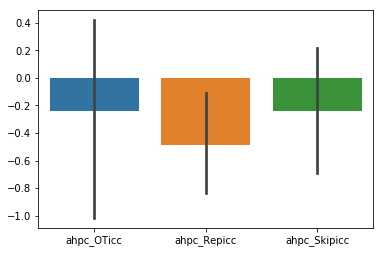

In [7]:
import seaborn as sns
ax = sns.barplot(data=trials_df[['ahpc_OTicc', 'ahpc_Repicc','ahpc_Skipicc']])

#ax = sns.barplot(data=trials_df[['mpfc_OTcic', 'mpfc_Repcic','mpfc_Skipcic']])



#stats.ttest_rel(trials_df['anthpc_linrep'], trials_df['anthpc_linskp'])

# * * * OLD CODE * * *

In [18]:
#all_data_df.to_csv('mpfc_ICC_ot_rep_skip.csv')

In [34]:
#Something is wrong... it gives the same data as mpfc
proj_dir = '/home/data/madlab/data/mri/seqtrd'

#sids = sorted(os.listdir('/home/data/madlab/data/mri/seqtrd/seqbl_1stpos_lag_normstats_FINALSAMPLE/'))
#sids = { '783126'}
sids = { '783126', '783127', '783130', '783131', '783132', '783133', 
        '783135', '783136', '783137', '783138', '783139', '783142', '783144', '783146',
        '783147', '783148', '783149', '783150', '783151', '783152', '783153', '783154', '783155',
        '783157', '783158',  '783163'}
#sids_no_repincor = 783129, 783128, 40, 41, 56, 59 <-- check these!
#sids_no_OTcor = 783125, 783134, 783143
#thrown out sids = 783145, 783160, 783161, 783162

#
#mask is the HC cluster
#cope is the BOLD data linskpos1topos3

#making cope variables
hc_mask_filenames = []
cope_OTcorr_files = []
cope_OTincorr_files = []
cope_Repcorr_files = []
cope_Repincorr_files = []
cope_Skipincorr_files = []
cope_Skipcorr_files = []
cope_OTcic_files = []
cope_OTicc_files = []
cope_Repcic_files = []
cope_Repicc_files = []
cope_Skipcic_files = []
cope_Skipicc_files    = []
    


#right now its grabbing the masks from the sink dir

for SID in sids:
    #/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/783125/anat_masks/_subject_id_783125
    #mask_filenames_glob = glob('/scratch/madlab/seqtrd/anatroi_sinkdir/seqbl_lag_cic/' + SID + '/anat_masks/*/*')
    #mask_filenames_glob = glob(proj_dir + '/mask/cortical_rois/' + SID + '/anat_masks/*/*')
    #mask_filenames_glob = glob(proj_dir + '/mask/cortical_rois/' + SID + '/anat_masks/*/*')
    
    hc_mask_glob = glob(proj_dir + '/mask/cortical_rois/' + SID + '/anat_masks/*/x_bihemi_ant_hpc_warped.nii.gz')
    hc_mask_filenames.append(hc_mask_glob)

    
    #OT cic
    curr_OTcic_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_OTCorr_minus_OTIncorr.nii.gz')
    cope_OTcic_files.append(curr_OTcic_filenames_glob)
    
    #OT icc
    curr_OTicc_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_OTIncorr_minus_OTCorr.nii.gz')
    cope_OTicc_files.append(curr_OTicc_filenames_glob)
    
    #rep cic
    curr_Repcic_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_RepeatCorr_minus_RepeatIncorr.nii.gz')
    cope_Repcic_files.append(curr_Repcic_filenames_glob)    
    
    #rep icc
    curr_Repicc_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_RepeatIncorr_minus_InseqCorr.nii.gz')
    cope_Repicc_files.append(curr_Repicc_filenames_glob)
    
    #skip cic
    curr_Skipcic_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_SkipCorr_minus_SkipIncorr.nii.gz')
    cope_Skipcic_files.append(curr_Skipcic_filenames_glob)
    
    #skip icc
    curr_Skipicc_filenames_glob = glob(proj_dir + '/scndlvl/seq_1stpos_cic_FINAL/' + SID + '/seq_1stpos_cic_bl/fixedfx/cope_skipIncorr_minus_SkipCorr.nii.gz') 
    cope_Skipicc_files.append(curr_Skipicc_filenames_glob)     


    

In [35]:

hc_all_data = {'hc_Repicc':[],'hc_Repcic':[],
            'hc_Skipicc':[],'hc_Skipcic':[],
            'hc_OTicc':[],'hc_OTcic':[],
           }

for i in range(len(sids)):
    #all_data['subjid'].append(sids[i])
    
    #What are these numbers? They come from the cell before from glob. The mpfc for example is the second one in the list.
    #and the left anthpc is the 5th one in the list as you can se a
    #mask_mpfc_img = nib.load(mask_filenames[i][0])
    currsubj_hc_img = nib.load(hc_mask_filenames[i][0])
    #FIX THISSSS************************************


        
    #hc_repicc           
    if len(cope_Repicc_files[i]) == 0:
        hc_all_data['hc_Repicc'].append(np.nan)
    else:
        currsubj_hc_img = nib.load(cope_Repicc_files[i][0])
        currsubj_hc_Repicc_data = currsubj_hc_img.get_data()[currsubj_hc_img.get_data() > 0.]
        hc_all_data['hc_Repicc'].append(np.mean(currsubj_hc_Repicc_data))
        
    #hc_repcic           
    if len(cope_Repcic_files[i]) == 0:
        hc_all_data['hc_Repcic'].append(np.nan)
    else:
        currsubj_hc_img = nib.load(cope_Repcic_files[i][0])
        currsubj_hc_Repcic_data = currsubj_hc_img.get_data()[currsubj_hc_img.get_data() > 0.]
        hc_all_data['hc_Repcic'].append(np.mean(currsubj_hc_Repcic_data))
        
    
    #hc_skpicc             
    if len(cope_Skipicc_files[i]) == 0:
        hc_all_data['hc_Skipicc'].append(np.nan)
    else:
        currsubj_hc_img = nib.load(cope_Skipicc_files[i][0])
        currsubj_hc_Skipicc_data = currsubj_hc_img.get_data()[currsubj_hc_img.get_data() > 0.]
        hc_all_data['hc_Skipicc'].append(np.mean(currsubj_hc_Skipicc_data))
        
    #hc_skpicc             
    if len(cope_Skipicc_files[i]) == 0:
        hc_all_data['hc_Skipcic'].append(np.nan)
    else:
        currsubj_hc_img = nib.load(cope_Skipcic_files[i][0])
        currsubj_hc_Skipcic_data = currsubj_hc_img.get_data()[currsubj_hc_img.get_data() > 0.]
        hc_all_data['hc_Skipcic'].append(np.mean(currsubj_hc_Skipcic_data))
    
    #hc_oticc           
    if len(cope_OTicc_files[i]) == 0:
        hc_all_data['hc_OTicc'].append(np.nan)
    else:
        currsubj_hc_img = nib.load(cope_OTicc_files[i][0])
        currsubj_hc_OTicc_data = currsubj_hc_img.get_data()[currsubj_hc_img.get_data() > 0.]
        hc_all_data['hc_OTicc'].append(np.mean(currsubj_hc_OTicc_data))
    
    #hc_oticc           
    if len(cope_OTcic_files[i]) == 0:
        hc_all_data['hc_OTcic'].append(np.nan)
    else:
        currsubj_hc_img = nib.load(cope_OTcic_files[i][0])
        currsubj_hc_OTcic_data = currsubj_hc_img.get_data()[currsubj_hc_img.get_data() > 0.]
        hc_all_data['hc_OTcic'].append(np.mean(currsubj_hc_OTcic_data))
    
    

hc_all_data_df = pd.DataFrame(hc_all_data)
hc_all_data_df.index = sids
hc_all_data_df.sort_index(ascending = True)


,hc_OTcic,hc_OTicc,hc_Repcic,hc_Repicc,hc_Skipcic,hc_Skipicc
783126,3.222309,3.291129,2.570468,2.977174,2.726189,1.915984
783127,1.284420,1.201133,1.993236,2.166172,1.253208,1.359341
783130,2.511358,3.081059,3.706629,3.165944,1.330318,2.807680
783131,2.188727,5.047004,2.574231,2.055060,1.651156,1.694738
783132,1.126291,2.200257,1.851306,1.450255,2.493362,1.983065
783133,2.117142,4.899856,2.841498,1.863416,1.908903,2.507041
783135,1.806460,2.484005,3.021060,2.511274,1.700874,1.943974
783136,2.115537,1.604480,2.482601,2.027278,2.181821,2.013333
783137,2.020085,1.726404,2.086111,1.701926,1.715447,3.202268
783138,1.444203,1.636275,2.366396,1.513788,1.772862,3.842126


In [36]:
hc_all_data_df.mean(axis = 0)

hc_OTcic      2.862707
hc_OTicc      2.844470
hc_Repcic     2.461220
hc_Repicc     2.132041
hc_Skipcic    1.974221
hc_Skipicc    2.185911
dtype: float64

In [50]:
#all_data_df.to_csv('/home/data/madlab/data/mri/seqtrd/HC_mPFC_OT_rep_skip_ROIs_0319.csv')

In [32]:

mpfc_all_data = {'mpfc_Repicc':[],'mpfc_Repcic':[],
            'mpfc_Skipicc':[],'mpfc_Skipcic':[],
            'mpfc_OTicc':[],'mpfc_OTcic':[],
           }

for i in range(len(sids)):
    #all_data['subjid'].append(sids[i])
    
    #What are these numbers? They come from the cell before from glob. The mpfc for example is the second one in the list.
    #and the left anthpc is the 5th one in the list as you can se a
    #mask_mpfc_img = nib.load(mask_filenames[i][0])
    currsubj_mpfc_img = nib.load(mpfc_mask_filenames[i][0])
    #FIX THISSSS************************************

    
    #Here nibabel converts 3D or 4D data into a numpy array
    #getting functional data within the mask
    # HPC linskip

        
    #mpfc_repicc
    if len(cope_Repicc_files[i]) == 0:
        mpfc_all_data['mpfc_Repicc'].append(np.nan)
    else:
        currsubj_mpfc_img = nib.load(cope_Repicc_files[i][0])
        currsubj_mpfc_Repicc_data = currsubj_mpfc_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        mpfc_all_data['mpfc_Repicc'].append(np.mean(currsubj_mpfc_Repicc_data))
    
    #mpfc_repcic
    if len(cope_Repcic_files[i]) == 0:
        mpfc_all_data['mpfc_Repcic'].append(np.nan)
    else:
        currsubj_mpfc_img = nib.load(cope_Repcic_files[i][0])
        currsubj_mpfc_Repcic_data = currsubj_mpfc_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        mpfc_all_data['mpfc_Repcic'].append(np.mean(currsubj_mpfc_Repcic_data))
        
    
    #mpfc_skpicc           
    if len(cope_Skipicc_files[i]) == 0:
        mpfc_all_data['mpfc_Skipicc'].append(np.nan)
    else:
        currsubj_mpfc_img = nib.load(cope_Skipicc_files[i][0])
        currsubj_mpfc_Skipicc_data = currsubj_mpfc_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        mpfc_all_data['mpfc_Skipicc'].append(np.mean(currsubj_mpfc_Skipicc_data))
    
    #mpfc_skpcic           
    if len(cope_Skipcic_files[i]) == 0:
        mpfc_all_data['mpfc_Skipcic'].append(np.nan)
    else:
        currsubj_mpfc_img = nib.load(cope_Skipcic_files[i][0])
        currsubj_mpfc_Skipcic_data = currsubj_mpfc_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        mpfc_all_data['mpfc_Skipcic'].append(np.mean(currsubj_mpfc_Skipcic_data))
        
        
    #mpfc_oticc           
    if len(cope_OTicc_files[i]) == 0:
        mpfc_all_data['mpfc_OTicc'].append(np.nan)
    else:
        currsubj_mpfc_img = nib.load(cope_OTicc_files[i][0])
        currsubj_mpfc_OTicc_data = currsubj_mpfc_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        mpfc_all_data['mpfc_OTicc'].append(np.mean(currsubj_mpfc_OTicc_data))
        
    #mpfc_otcic           
    if len(cope_OTcic_files[i]) == 0:
        mpfc_all_data['mpfc_OTcic'].append(np.nan)
    else:
        currsubj_mpfc_img = nib.load(cope_OTcic_files[i][0])
        currsubj_mpfc_OTcic_data = currsubj_mpfc_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
        mpfc_all_data['mpfc_OTcic'].append(np.mean(currsubj_mpfc_OTcic_data))
    
    

mpfc_all_data_df = pd.DataFrame(mpfc_all_data)
mpfc_all_data_df.index = sids
mpfc_all_data_df.sort_index(ascending = True)


,mpfc_OTcic,mpfc_OTicc,mpfc_Repcic,mpfc_Repicc,mpfc_Skipcic,mpfc_Skipicc
783126,3.222309,3.291129,2.570468,2.977174,2.726189,1.915984
783127,1.284420,1.201133,1.993236,2.166172,1.253208,1.359341
783130,2.511358,3.081059,3.706629,3.165944,1.330318,2.807680
783131,2.188727,5.047004,2.574231,2.055060,1.651156,1.694738
783132,1.126291,2.200257,1.851306,1.450255,2.493362,1.983065
783133,2.117142,4.899856,2.841498,1.863416,1.908903,2.507041
783135,1.806460,2.484005,3.021060,2.511274,1.700874,1.943974
783136,2.115537,1.604480,2.482601,2.027278,2.181821,2.013333
783137,2.020085,1.726404,2.086111,1.701926,1.715447,3.202268
783138,1.444203,1.636275,2.366396,1.513788,1.772862,3.842126


# Old code

In [ ]:
#defining the workflow directories
subjects_dir = '/home/data/madlab/surfaces/seqtrd'
work_dir = '/scratch/madlab/seqtrd/anatroi_workdir/seqbl_lag_cic'
sink_dir = '/scratch/madlab/seqtrd/ROI/Inc-corr_ot_rep_skip'
#sink_dir = '/home/data/madlab/data/mri/seqtrd/mask/ant_HC/'

#subjects that we iterate over (functional data)
#sids = os.listdir('/home/data/madlab/data/mri/seqtrd/frstlvl/seqbl_1st_laganalysis')

wf = pe.Workflow(name='wf')
wf.base_dir = work_dir

# Node: subject_iterable
subj_iterable = pe.Node(util.IdentityInterface(fields=['subject_id'], mandatory_inputs=True),
                        name='subj_iterable')
subj_iterable.iterables = ('subject_id', sids)

# Grabbing data
info = dict(ref_epi_file=[['subject_id']],
            bbreg_xfm=[['subject_id']],
            hpc_ap_mask=[['subject_id']],
            aparc_aseg=[['subject_id']])

datasource = pe.Node(nio.DataGrabber(infields=['subject_id'],
                                     outfields=info.keys()),
                                     name='datasource')
datasource.inputs.base_directory = os.path.abspath('/home/data/madlab/')
datasource.inputs.field_template = dict(ref_epi_file='data/mri/seqtrd/preproc/%s/seq/ref/*.nii.gz',
                                        bbreg_xfm='data/mri/seqtrd/preproc/%s/seq/bbreg/_fs_register0/*.dat',
                                        hpc_ap_mask='data/mri/seqtrd/ant_post_hpc_mask/%s/mask_resample.nii.gz',
                                        aparc_aseg='surfaces/seqtrd/%s/mri/aparc+aseg.mgz')

#datasource.inputs.subject_id = sids[0]
datasource.inputs.template = '*'
datasource.inputs.template_args = info
datasource.inputs.sort_filelist = True
datasource.inputs.ignore_exception = False
datasource.inputs.raise_on_empty = True
wf.connect(subj_iterable, 'subject_id', datasource, 'subject_id')

# Extract whole hippocampus (bilateral) as binary mask
#whole_hpc_mask = pe.Node(fs.Binarize(), 
#                       name='whole_hpc_mask')
#whole_hpc_mask.inputs.match = [1,2,21,22]
#whole_hpc_mask.inputs.binary_file = 'hpc.nii.gz'
#wf.connect(datasource, 'hpc_ap_mask', whole_hpc_mask, 'in_file')

# Extract anterior hippocampus (bilateral) as binary mask
#ant_hpc_mask = pe.Node(fs.Binarize(), 
#                       name='ant_hpc_mask')
#ant_hpc_mask.inputs.match = [1, 21]
#ant_hpc_mask.inputs.binary_file = 'ant_hpc.nii.gz'
#wf.connect(datasource, 'hpc_ap_mask', ant_hpc_mask, 'in_file')

# Extract anterior hippocampus (bilateral) as binary mask
r_ant_hpc_mask = pe.Node(fs.Binarize(), 
                       name='r_ant_hpc_mask')
r_ant_hpc_mask.inputs.match = [1]
r_ant_hpc_mask.inputs.binary_file = 'r_ant_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', r_ant_hpc_mask, 'in_file')

# Extract posterior hippocampus (bilateral) as binary mask
#r_post_hpc_mask = pe.Node(fs.Binarize(), 
#                        name='r_post_hpc_mask')
#r_post_hpc_mask.inputs.match = [2]
#r_post_hpc_mask.inputs.binary_file = 'r_post_hpc.nii.gz'
#wf.connect(datasource, 'hpc_ap_mask', r_post_hpc_mask, 'in_file')

l_ant_hpc_mask = pe.Node(fs.Binarize(), 
                       name='l_ant_hpc_mask')
l_ant_hpc_mask.inputs.match = [21]
l_ant_hpc_mask.inputs.binary_file = 'l_ant_hpc.nii.gz'
wf.connect(datasource, 'hpc_ap_mask', l_ant_hpc_mask, 'in_file')

# Extract anterior hippocampus (bilateral) as binary mask
#l_ant_hpc_mask = pe.Node(fs.Binarize(), 
#                       name='l_ant_hpc_mask')
#l_ant_hpc_mask.inputs.match = [21]
#l_ant_hpc_mask.inputs.binary_file = 'l_ant_hpc.nii.gz'
#This is the outputfile name
#wf.connect(datasource, 'hpc_ap_mask', l_ant_hpc_mask, 'in_file')

# Extract posterior hippocampus (bilateral) as binary mask
#l_post_hpc_mask = pe.Node(fs.Binarize(), 
#                        name='l_post_hpc_mask')
#l_post_hpc_mask.inputs.match = [22]
#l_post_hpc_mask.inputs.binary_file = 'l_post_hpc.nii.gz'
#wf.connect(datasource, 'hpc_ap_mask', l_post_hpc_mask, 'in_file')

#Extract mPFC (bilateral) as binary mask
#1002 and 2002 are l and r caudalte anterior cingulate
#1026 and 2026 are the l and r rostral anterior cingulate
#2 hemispheres together
#Here we use the aparc_aseg file from freesurfer as input (Automatedparcellation and automated segmentation)
#mpfc_mask = pe.Node(fs.Binarize(),
#                   name='mpfc_mask')
#mpfc_mask.inputs.match = [1002, 2002, 1026, 2026]
#mpfc_mask.inputs.binary_file = 'mpfc_bimask.nii.gz'
#wf.connect(datasource, 'aparc_aseg', mpfc_mask, 'in_file')


# Now transform the anterior HC binary mask to 1st volume of 1st run
#moving from freesurfer space into EPI space
#Taking the functional data from the mask area (technically registration).struc to func

#whole hpc
#whole_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
#                                           interp='nearest'),
#                      name='whole_hpc_xfm')
#whole_hpc_xfm.inputs.subjects_dir = subjects_dir
#wf.connect(datasource, 'ref_epi_file', whole_hpc_xfm, 'source_file')
#wf.connect(datasource, 'bbreg_xfm', whole_hpc_xfm, 'reg_file')
#wf.connect(whole_hpc_mask, 'binary_file', whole_hpc_xfm, 'target_file')

#anterior hpc
#ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
#                                           interp='nearest'),
#                      name='ant_hpc_xfm')
#ant_hpc_xfm.inputs.subjects_dir = subjects_dir
#wf.connect(datasource, 'ref_epi_file', ant_hpc_xfm, 'source_file')
#wf.connect(datasource, 'bbreg_xfm', ant_hpc_xfm, 'reg_file')
#wf.connect(ant_hpc_mask, 'binary_file', ant_hpc_xfm, 'target_file')


r_ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='r_ant_hpc_xfm')
r_ant_hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', r_ant_hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', r_ant_hpc_xfm, 'reg_file')
wf.connect(r_ant_hpc_mask, 'binary_file', r_ant_hpc_xfm, 'target_file')


l_ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
                                           interp='nearest'),
                      name='l_ant_hpc_xfm')
l_ant_hpc_xfm.inputs.subjects_dir = subjects_dir
wf.connect(datasource, 'ref_epi_file', l_ant_hpc_xfm, 'source_file')
wf.connect(datasource, 'bbreg_xfm', l_ant_hpc_xfm, 'reg_file')
wf.connect(l_ant_hpc_mask, 'binary_file', l_ant_hpc_xfm, 'target_file')

#l_ant_hpc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
#                                           interp='nearest'),
#                      name='l_ant_hpc_xfm')
#l_ant_hpc_xfm.inputs.subjects_dir = subjects_dir
#wf.connect(datasource, 'ref_epi_file', l_ant_hpc_xfm, 'source_file')
#wf.connect(datasource, 'bbreg_xfm', l_ant_hpc_xfm, 'reg_file')
#wf.connect(l_ant_hpc_mask, 'binary_file', l_ant_hpc_xfm, 'target_file')

# Now transform the mPFC mask to 1st volume of 1st run
#mpfc_xfm = pe.Node(fs.ApplyVolTransform(inverse=True,
#                                           interp='nearest'),
#                      name='mpfc_xfm')
#mpfc_xfm.inputs.subjects_dir = subjects_dir
#wf.connect(datasource, 'ref_epi_file', mpfc_xfm, 'source_file')
#wf.connect(datasource, 'bbreg_xfm', mpfc_xfm, 'reg_file')
#wf.connect(mpfc_mask, 'binary_file', mpfc_xfm, 'target_file')

# Node: sinker
#saves it
sinker = pe.Node(nio.DataSink(infields=None), name="sinker")
sinker.inputs._outputs = {}
sinker.inputs.base_directory = sink_dir
#container is the file it will be saved in 
#sinker.inputs.container = sids[0]
sinker.inputs.ignore_exception = False
sinker.inputs.parameterization = True
sinker.inputs.remove_dest_dir = False
wf.connect(subj_iterable, 'subject_id', sinker, 'container')
#wf.connect(whole_hpc_xfm, "transformed_file", sinker, "anat_masks.@wholehpc")
wf.connect(ant_hpc_xfm, "transformed_file", sinker, "anat_masks.@anthpc")
wf.connect(r_ant_hpc_xfm, "transformed_file", sinker, "anat_masks.@ranthpc")
wf.connect(l_ant_hpc_xfm, "transformed_file", sinker, "anat_masks.@lanthpc")

wf.run(plugin='SLURM', plugin_args={'sbatch_args': ('-p investor --qos pq_madlab -t 24:00:00 -N 1 -n 1 -e err -o out'), 'overwrite': True})

In [ ]:
import seaborn as sns
ax = sns.barplot(data=all_data_df[['anthpc_linrep', 'anthpc_linskp']])
stats.ttest_rel(all_data_df['anthpc_linrep'], all_data_df['anthpc_linskp'])

In [ ]:
print all_data_df['anthpc_linrep'].mean()
print all_data_df['anthpc_linskp'].mean()
print all_data_df['anthpc_Neglinrep'].mean()
print all_data_df['anthpc_Neglinskp'].mean()
ax = sns.barplot(data=all_data_df[['anthpc_linrep', 'anthpc_Neglinrep', 'anthpc_linskp','anthpc_Neglinskp']], ci="sd")

In [ ]:
print all_data_df['anthpc_linrep'].sem()
print all_data_df['anthpc_linskp'].sem()
print all_data_df['anthpc_Neglinrep'].sem()
print all_data_df['anthpc_Neglinskp'].sem()

In [ ]:
print "paired ttest between neglinrep and linskp"
print stats.ttest_rel(all_data_df['anthpc_Neglinrep'], all_data_df['anthpc_linskp'])
print "paired ttest between linrep and linskp"
print stats.ttest_rel(all_data_df['anthpc_linrep'], all_data_df['anthpc_linskp'])
print "paired ttest between neglinskp and linskp"
print stats.ttest_rel(all_data_df['anthpc_Neglinskp'], all_data_df['anthpc_linskp'])

In [ ]:
print stats.ttest_1samp(all_data_df['anthpc_linskp'], 0)
print stats.ttest_1samp(all_data_df['anthpc_Neglinskp'], 0)
print stats.ttest_1samp(all_data_df['anthpc_linrep'], 0)
print stats.ttest_1samp(all_data_df['anthpc_Neglinrep'], 0)

In [ ]:
import seaborn as sns
all_data_df_nonan = all_data_df.drop(['783125', '783129', '783134', '783140', '783145', '783156', '783161', '783162'])
ax = sns.barplot(data=all_data_df_nonan[['mpfc_ot_icc', 'mpfc_skip_cic', 'mpfc_repeat_cic']])
stats.ttest_rel(all_data_df_nonan['mpfc_ot_icc'], all_data_df_nonan['mpfc_skip_cic'])

In [ ]:
all_data_df

In [ ]:
high_ot_df.to_csv('/home/data/madlab/data/mri/seqtrd/scndlvl/high_ot_betaval.csv')

In [ ]:
proj_dir = '/home/data/madlab/data/mri/seqtrd'
 
#making cope variables
mask_filenames = []
cope_inseq_files = []
cope_skip_corr_files = []
cope_skip_incorr_files = []
cope_repeat_corr_files = []
cope_repeat_incorr_files = []
cope_ot_corr_files = []
cope_ot_incorr_files = []

#right now its grabbing the masks from the sink dir

for SID in sids:
    mask_filenames_glob = glob('/scratch/madlab/seqtrd/anatroi_sinkdir/' + SID + '/anat_masks/*/*')
    mask_filenames.append(mask_filenames_glob)   
    
    #In pos
    curr_inseq_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_inseq_matchedpos.nii.gz')
    cope_inseq_files.append(curr_inseq_filenames_glob)       
    
    #Skip correct pos
    curr_skip_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_skip_corr_pos.nii.gz')
    cope_skip_corr_files.append(curr_skip_corr_filenames_glob)
    
    #Skip incorrect pos
    curr_skip_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_skip_incorr_pos.nii.gz')
    cope_skip_incorr_files.append(curr_skip_incorr_filenames_glob)

    #Repeats correct pos
    curr_repeat_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_repeat_corr_pos.nii.gz')
    cope_repeat_corr_files.append(curr_repeat_corr_filenames_glob)
    
    #Repeats incorrect pos
    curr_repeat_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_repeat_incorr_pos.nii.gz')
    cope_repeat_incorr_files.append(curr_repeat_incorr_filenames_glob)

    #Ordinal transfers correct pos (not one of the copes for some reason)
    curr_ot_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_ot_corr_pos.nii.gz')
    cope_ot_corr_files.append(curr_ot_corr_filenames_glob)

    #Ordinal transfers correct pos
    curr_ot_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_ot_incorr_pos.nii.gz')
    cope_ot_incorr_files.append(curr_ot_incorr_filenames_glob)

In [ ]:
all_data = {'subjid':[], 'anthpc_inseq':[],'anthpc_skip_corr':[],'anthpc_skip_incorr':[],'anthpc_repeat_corr':[],
            'anthpc_ot_incorr':[],
            'mpfc_inseq':[],'mpfc_skip_corr':[],'mpfc_skip_incorr':[],'mpfc_repeat_corr':[],
            'mpfc_ot_incorr':[],
            'rerh_inseq':[],'rerh_skip_corr':[],'rerh_skip_incorr':[],'rerh_repeat_corr':[],
            'rerh_ot_incorr':[],
            'pvpt_inseq':[],'pvpt_skip_corr':[],'pvpt_skip_incorr':[],'pvpt_repeat_corr':[],
            'pvpt_ot_incorr':[],
           'anthpc_ot_corr':[], 'mpfc_ot_corr':[],'rerh_ot_corr':[],'pvpt_ot_corr':[],}
#            'anthpc_repeat_incorr':[], 'mpfc_repeat_incorr':[],'rerh_repeat_incorr':[],'pvpt_repeat_incorr':[],

for i in range(len(sids)):
    all_data['subjid'].append(sids[i])
    
    #What are these numbers? They come from the cell before from glob. The mpfc for example is the second one in the list.
    #and the left anthpc is the 5th one in the list as you can se a
    currsubj_l_anthpc_img = nib.load(mask_filenames[i][4])
    currsubj_r_anthpc_img = nib.load(mask_filenames[i][5])
    currsubj_l_posthpc_img = nib.load(mask_filenames[i][6])
    currsubj_r_posthpc_img = nib.load(mask_filenames[i][3]) 
    currsubj_mpfc_img = nib.load(mask_filenames[i][1])
    currsubj_rerh_img = nib.load(mask_filenames[i][9])
    currsubj_pvpt_img = nib.load(mask_filenames[i][8])
    currsubj_limbicthal_img = nib.load(mask_filenames[i][7])
    currsubj_inseq_img = nib.load(cope_inseq_files[i][0])
    currsubj_skip_corr_img = nib.load(cope_skip_corr_files[i][0])
    currsubj_skip_incorr_img = nib.load(cope_skip_incorr_files[i][0])
    currsubj_repeat_corr_img = nib.load(cope_repeat_corr_files[i][0])
#    currsubj_repeat_incorr_img = nib.load(cope_repeat_incorr_files[i][0])
    currsubj_ot_corr_img = nib.load(cope_ot_corr_files[i][0])
    currsubj_ot_incorr_img = nib.load(cope_ot_incorr_files[i][0])
    
    
    #Here nibabel converts 3D or 4D data into a numpy array
    #getting functional data within the mask
    #left anterior hpc
    currsubj_anthpc_inseq_data = currsubj_inseq_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_inseq'].append(np.mean(currsubj_anthpc_inseq_data))
    currsubj_anthpc_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_skip_corr'].append(np.mean(currsubj_anthpc_skip_corr_data))
    currsubj_anthpc_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_skip_incorr'].append(np.mean(currsubj_anthpc_skip_incorr_data))
    currsubj_anthpc_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_repeat_corr'].append(np.mean(currsubj_anthpc_repeat_corr_data))
#    currsubj_anthpc_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
#    all_data['anthpc_repeat_incorr'].append(np.mean(currsubj_anthpc_repeat_incorr_data))    
    currsubj_anthpc_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_ot_corr'].append(np.mean(currsubj_anthpc_ot_corr_data))
    currsubj_anthpc_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_ot_incorr'].append(np.mean(currsubj_anthpc_ot_incorr_data))

    
    
    #mpfc
    currsubj_mpfc_inseq_data = currsubj_inseq_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_inseq'].append(np.mean(currsubj_mpfc_inseq_data))
    currsubj_mpfc_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_skip_corr'].append(np.mean(currsubj_mpfc_skip_corr_data))
    currsubj_mpfc_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_skip_incorr'].append(np.mean(currsubj_mpfc_skip_incorr_data))
    currsubj_mpfc_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_repeat_corr'].append(np.mean(currsubj_mpfc_repeat_corr_data))
#    currsubj_mpfc_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
#    all_data['mpfc_repeat_incorr'].append(np.mean(currsubj_mpfc_repeat_incorr_data))    
    currsubj_mpfc_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_ot_corr'].append(np.mean(currsubj_mpfc_ot_corr_data))
    currsubj_mpfc_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_ot_incorr'].append(np.mean(currsubj_mpfc_ot_incorr_data))

    
    #rerh
    currsubj_rerh_inseq_data = currsubj_inseq_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_inseq'].append(np.mean(currsubj_rerh_inseq_data))
    currsubj_rerh_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_skip_corr'].append(np.mean(currsubj_rerh_skip_corr_data))
    currsubj_rerh_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_skip_incorr'].append(np.mean(currsubj_rerh_skip_incorr_data))
    currsubj_rerh_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_repeat_corr'].append(np.mean(currsubj_rerh_repeat_corr_data))
#    currsubj_rerh_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
#    all_data['rerh_repeat_incorr'].append(np.mean(currsubj_rerh_repeat_incorr_data))    
    currsubj_rerh_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_ot_corr'].append(np.mean(currsubj_rerh_ot_corr_data))
    currsubj_rerh_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_ot_incorr'].append(np.mean(currsubj_rerh_ot_incorr_data))    

    #pvpt
    currsubj_pvpt_inseq_data = currsubj_inseq_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_inseq'].append(np.mean(currsubj_pvpt_inseq_data))
    currsubj_pvpt_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_skip_corr'].append(np.mean(currsubj_pvpt_skip_corr_data))
    currsubj_pvpt_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_skip_incorr'].append(np.mean(currsubj_pvpt_skip_incorr_data))
    currsubj_pvpt_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_repeat_corr'].append(np.mean(currsubj_pvpt_repeat_corr_data))
#    currsubj_pvpt_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
#    all_data['pvpt_repeat_incorr'].append(np.mean(currsubj_pvpt_repeat_incorr_data))    
    currsubj_pvpt_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_ot_corr'].append(np.mean(currsubj_pvpt_ot_corr_data))
    currsubj_pvpt_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_ot_incorr'].append(np.mean(currsubj_pvpt_ot_incorr_data)) 

In [ ]:
low_ot_df = pd.DataFrame(all_data)
low_ot_df.index = sids

In [ ]:
low_ot_df

In [ ]:
low_ot_df.to_csv('/home/data/madlab/data/mri/seqtrd/scndlvl/low_ot_betaval.csv')

In [ ]:
#sids that dont have copes: 783129, 783131, 783143, 783158, 783162(doesnt have repeat corr or skip corr)
#sids without repeat incorrect copes: 783128, 783140, 783141, 783156, 783159
#sids without OT correct copes: 783125, 783134, 783142, 783147, 783151, 783154, 783157

#Next we look at the copes for position matched
#sids = os.listdir('/home/data/madlab/data/mri/seqtrd/scndlvl/seqbl_posplus_corrincorr')

#sids with low ot accuracy
#sids = ('783130','783132','783133','783138','783139',
#        '783141','783144','783145','783146','783152') 
        #no copes:'783131','783162'
        #no ot corr:
sids = ('783125','783134','783142','783147','783151','783154','783157')

#sids with high ot accuracy
#sids = ('783126','783127','783128','783135','783136','783137','783140',
#        '783148','783149','783150','783153','783155','783156',
#        '783159','783161') 
        #no copes:'783129','783143','783158',
        #783163 has crazy high numbers

In [ ]:
proj_dir = '/home/data/madlab/data/mri/seqtrd'
 
#making cope variables
mask_filenames = []
cope_inseq_files = []
cope_skip_corr_files = []
cope_skip_incorr_files = []
cope_repeat_corr_files = []
cope_repeat_incorr_files = []
cope_ot_corr_files = []
cope_ot_incorr_files = []

#right now its grabbing the masks from the sink dir

for SID in sids:
    mask_filenames_glob = glob('/scratch/madlab/seqtrd/anatroi_sinkdir/' + SID + '/anat_masks/*/*')
    mask_filenames.append(mask_filenames_glob)   
    
    #In pos
    curr_inseq_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_inseq_matchedpos.nii.gz')
    cope_inseq_files.append(curr_inseq_filenames_glob)       
    
    #Skip correct pos
    curr_skip_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_skip_corr_pos.nii.gz')
    cope_skip_corr_files.append(curr_skip_corr_filenames_glob)
    
    #Skip incorrect pos
    curr_skip_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_skip_incorr_pos.nii.gz')
    cope_skip_incorr_files.append(curr_skip_incorr_filenames_glob)

    #Repeats correct pos
    curr_repeat_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_repeat_corr_pos.nii.gz')
    cope_repeat_corr_files.append(curr_repeat_corr_filenames_glob)
    
    #Repeats incorrect pos
    curr_repeat_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_repeat_incorr_pos.nii.gz')
    cope_repeat_incorr_files.append(curr_repeat_incorr_filenames_glob)

    #Ordinal transfers correct pos (not one of the copes for some reason)
    curr_ot_corr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_ot_corr_pos.nii.gz')
    cope_ot_corr_files.append(curr_ot_corr_filenames_glob)

    #Ordinal transfers correct pos
    curr_ot_incorr_filenames_glob = glob(proj_dir + '/scndlvl/seqbl_posplus_corrincorr/' + SID + '/seq_pos_bl/fixedfx/cope_ot_incorr_pos.nii.gz')
    cope_ot_incorr_files.append(curr_ot_incorr_filenames_glob)

In [ ]:
mask_filenames_glob

In [ ]:
all_data = {'subjid':[], 'anthpc_inseq':[],'anthpc_skip_corr':[],'anthpc_skip_incorr':[],'anthpc_repeat_corr':[],
            'anthpc_ot_incorr':[],
            'mpfc_inseq':[],'mpfc_skip_corr':[],'mpfc_skip_incorr':[],'mpfc_repeat_corr':[],
            'mpfc_ot_incorr':[],
            'rerh_inseq':[],'rerh_skip_corr':[],'rerh_skip_incorr':[],'rerh_repeat_corr':[],
            'rerh_ot_incorr':[],
            'pvpt_inseq':[],'pvpt_skip_corr':[],'pvpt_skip_incorr':[],'pvpt_repeat_corr':[],
            'pvpt_ot_incorr':[]}
#           'anthpc_ot_corr':[], 'mpfc_ot_corr':[],'rerh_ot_corr':[],'pvpt_ot_corr':[],}
#            'anthpc_repeat_incorr':[], 'mpfc_repeat_incorr':[],'rerh_repeat_incorr':[],'pvpt_repeat_incorr':[],

for i in range(len(sids)):
    all_data['subjid'].append(sids[i])
    
    #What are these numbers? They come from the cell before from glob. The mpfc for example is the second one in the list.
    #and the left anthpc is the 5th one in the list as you can se a
    currsubj_mpfc_img = nib.load(mask_filenames[i][1])
    currsubj_r_posthpc_img = nib.load(mask_filenames[i][3])
    currsubj_l_anthpc_img = nib.load(mask_filenames[i][4])
    currsubj_r_anthpc_img = nib.load(mask_filenames[i][5])
    currsubj_l_posthpc_img = nib.load(mask_filenames[i][6]) 
    currsubj_rerh_img = nib.load(mask_filenames[i][9])
    currsubj_pvpt_img = nib.load(mask_filenames[i][8])
    currsubj_limbicthal_img = nib.load(mask_filenames[i][7])
    currsubj_inseq_img = nib.load(cope_inseq_files[i][0])
    currsubj_skip_corr_img = nib.load(cope_skip_corr_files[i][0])
    currsubj_skip_incorr_img = nib.load(cope_skip_incorr_files[i][0])
    currsubj_repeat_corr_img = nib.load(cope_repeat_corr_files[i][0])
#    currsubj_repeat_incorr_img = nib.load(cope_repeat_incorr_files[i][0])
#    currsubj_ot_corr_img = nib.load(cope_ot_corr_files[i][0])
    currsubj_ot_incorr_img = nib.load(cope_ot_incorr_files[i][0])
    
    
    #Here nibabel converts 3D or 4D data into a numpy array
    #getting functional data within the mask
    #left anterior hpc
    currsubj_anthpc_inseq_data = currsubj_inseq_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_inseq'].append(np.mean(currsubj_anthpc_inseq_data))
    currsubj_anthpc_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_skip_corr'].append(np.mean(currsubj_anthpc_skip_corr_data))
    currsubj_anthpc_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_skip_incorr'].append(np.mean(currsubj_anthpc_skip_incorr_data))
    currsubj_anthpc_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_repeat_corr'].append(np.mean(currsubj_anthpc_repeat_corr_data))
#    currsubj_anthpc_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
#    all_data['anthpc_repeat_incorr'].append(np.mean(currsubj_anthpc_repeat_incorr_data))    
#    currsubj_anthpc_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
#    all_data['anthpc_ot_corr'].append(np.mean(currsubj_anthpc_ot_corr_data))
    currsubj_anthpc_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_anthpc_img.get_data() > 0.]
    all_data['anthpc_ot_incorr'].append(np.mean(currsubj_anthpc_ot_incorr_data))

    
    
    #mpfc
    currsubj_mpfc_inseq_data = currsubj_inseq_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_inseq'].append(np.mean(currsubj_mpfc_inseq_data))
    currsubj_mpfc_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_skip_corr'].append(np.mean(currsubj_mpfc_skip_corr_data))
    currsubj_mpfc_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_skip_incorr'].append(np.mean(currsubj_mpfc_skip_incorr_data))
    currsubj_mpfc_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_repeat_corr'].append(np.mean(currsubj_mpfc_repeat_corr_data))
#    currsubj_mpfc_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
#    all_data['mpfc_repeat_incorr'].append(np.mean(currsubj_mpfc_repeat_incorr_data))    
 #   currsubj_mpfc_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
#    all_data['mpfc_ot_corr'].append(np.mean(currsubj_mpfc_ot_corr_data))
    currsubj_mpfc_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_mpfc_img.get_data() > 0.]
    all_data['mpfc_ot_incorr'].append(np.mean(currsubj_mpfc_ot_incorr_data))

    
    #rerh
    currsubj_rerh_inseq_data = currsubj_inseq_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_inseq'].append(np.mean(currsubj_rerh_inseq_data))
    currsubj_rerh_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_skip_corr'].append(np.mean(currsubj_rerh_skip_corr_data))
    currsubj_rerh_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_skip_incorr'].append(np.mean(currsubj_rerh_skip_incorr_data))
    currsubj_rerh_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_repeat_corr'].append(np.mean(currsubj_rerh_repeat_corr_data))
#    currsubj_rerh_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
#    all_data['rerh_repeat_incorr'].append(np.mean(currsubj_rerh_repeat_incorr_data))    
 #   currsubj_rerh_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
#    all_data['rerh_ot_corr'].append(np.mean(currsubj_rerh_ot_corr_data))
    currsubj_rerh_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_rerh_img.get_data() > 0.]
    all_data['rerh_ot_incorr'].append(np.mean(currsubj_rerh_ot_incorr_data))    

    #pvpt
    currsubj_pvpt_inseq_data = currsubj_inseq_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_inseq'].append(np.mean(currsubj_pvpt_inseq_data))
    currsubj_pvpt_skip_corr_data = currsubj_skip_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_skip_corr'].append(np.mean(currsubj_pvpt_skip_corr_data))
    currsubj_pvpt_skip_incorr_data = currsubj_skip_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_skip_incorr'].append(np.mean(currsubj_pvpt_skip_incorr_data))
    currsubj_pvpt_repeat_corr_data = currsubj_repeat_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_repeat_corr'].append(np.mean(currsubj_pvpt_repeat_corr_data))
#    currsubj_pvpt_repeat_incorr_data = currsubj_repeat_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
#    all_data['pvpt_repeat_incorr'].append(np.mean(currsubj_pvpt_repeat_incorr_data))    
 #   currsubj_pvpt_ot_corr_data = currsubj_ot_corr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
#    all_data['pvpt_ot_corr'].append(np.mean(currsubj_pvpt_ot_corr_data))
    currsubj_pvpt_ot_incorr_data = currsubj_ot_incorr_img.get_data()[currsubj_pvpt_img.get_data() > 0.]
    all_data['pvpt_ot_incorr'].append(np.mean(currsubj_pvpt_ot_incorr_data)) 

In [ ]:
lowest_ot_df = pd.DataFrame(all_data)
lowest_ot_df.index = sids

In [ ]:
lowest_ot_df

In [ ]:
lowest_ot_df.to_csv('/home/data/madlab/data/mri/seqtrd/scndlvl/lowest_ot_betaval.csv')